In [2]:

# Imports and Setup
import os
import sys
import json
import pickle
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import jax
from jax import jit
import jax.numpy as jnp
import jax.scipy.integrate as integrate

# Custom imports



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


from Helper import *
from Image import *
from Psi import *
from Optimize import *


class ConfigurableModel(nn.Module):
    def __init__(self, architecture, activation_fn=torch.relu, dropout_rate=0.0, input_dim=2882, output_dim=12):
        super().__init__()
        layers = []
        in_features = input_dim
        for size in architecture:
            layers.append(nn.Linear(in_features, size))
            layers.append(nn.Dropout(dropout_rate))
            layers.append(activation_fn())
            in_features = size
        layers.append(nn.Linear(in_features, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



# Matplotlib settings
plt.rcParams.update({'font.size': 22})
rcParams["figure.figsize"] = (30, 10)
plt.rcParams["savefig.dpi"] = 300

# Parameters
SAMPLE_IDX = 0
DX = 0.25
ISLR_RADIUS = 5 # min distance between scatterers
ISLR_RADIUS_RATIO = 0.6 # ratio of radius for sidelobe integral
ISLR_MAIN_LOBE_WIDTH = 0.75 #fixed main lobe width
COMPARISON_SAMPLE_SIZE = 10

# File paths -- MAKE SURE THERYE TEST FILES
DATA_DIR = "/home/houtlaw/iono-net/data/baselines/30k_baseline"
X_RANGE_PATH = f"{DATA_DIR}/meta_X_20250204_132405.csv"
SETUP_PATH = f"{DATA_DIR}/setup_20250204_132405.json"
SCATTERER_PATH_RELNOISE = f"{DATA_DIR}/train_nuStruct_withSpeckle_20250204_132249.csv"
SIGNAL_PATH_RELNOISE = f"{DATA_DIR}/train_uscStruct_vals_20250204_132324.csv"
KPSI_PATH = f"{DATA_DIR}/kPsi_20250204_132405.csv"
PSI_COEFFS_PATH_RELNOISE = f"{DATA_DIR}/train_compl_ampls_20250204_132323.csv"
MODEL_WEIGHTS_PATH = "/home/houtlaw/iono-net/model/torch_model_weights_single.pkl"

# Helper Functions
def convert_to_complex(s):
    s = str(s)
    if s == "NaNNaNi":
        return 0
    return complex(s.replace('i', 'j'))

def normalize_complex_to_unit_range(matrix):
    amp = np.abs(matrix)
    amp_max = np.max(amp, axis=1, keepdims=True)
    amp_max[amp_max == 0] = 1
    normalized = matrix / amp_max
    return normalized.real + 1j * normalized.imag

def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)

def linear_interp_pytorch(base, x, y):
    indices = torch.searchsorted(x, base, right=False)
    indices = torch.clamp(indices, 1, x.shape[0] - 1)
    x0 = x[indices - 1]
    x1 = x[indices]
    y0 = y[indices - 1]
    y1 = y[indices]
    slope = (y1 - y0) / (x1 - x0 + 1e-12)
    return y0 + slope * (base - x0)

def calculate_l4_norm_torch_differentiable(signal_vals, preds_real, preds_imag,
                                           x_range_tensor, kpsi_tensor, F, DX, xi, zero_pad):
    # Ensure double precision
    signal_vals = signal_vals.double()
    preds_real = preds_real.double()
    preds_imag = preds_imag.double()
    x_range_tensor = x_range_tensor.double()
    kpsi_tensor = kpsi_tensor.double()

    # Construct complex signal
    signal_real = signal_vals[:1441]
    signal_imag = signal_vals[1441:]
    signal_complex = signal_real + 1j * signal_imag

    # Trim signal and x_range
    signal_trimmed = signal_complex[4 * zero_pad : -4 * zero_pad].to(device)
    x_trimmed = x_range_tensor[4 * zero_pad : -4 * zero_pad].to(device)

    # Define window size
    window_size = int(F / DX) + 1
    offsets = torch.linspace(-F / 2, F / 2, window_size, device=device, dtype=torch.float64)

    image_vals = []

    for y in x_trimmed:
        base = y + offsets
        sarr = xi * base + (1 - xi) * y

        # Interpolate signal
        real_interp = linear_interp_pytorch(base, x_trimmed, signal_trimmed.real)
        imag_interp = linear_interp_pytorch(base, x_trimmed, signal_trimmed.imag)
        signal_interp = real_interp + 1j * imag_interp

        # Apply window
        window = torch.ones_like(base)  # rect_window: uniform window
        waveform = torch.exp(-1j * torch.pi * (base - y) ** 2 / F)

        # Compute Psi
        outer = torch.outer(sarr, kpsi_tensor).T  # shape (Nharm, window_size)
        psi_cos = torch.sum(preds_real[:, None] * torch.cos(outer), dim=0)
        psi_sin = torch.sum(preds_imag[:, None] * torch.sin(outer), dim=0)
        psi_vals = torch.exp(1j * (psi_cos - psi_sin))

        # Final integrand and image value
        integrand = waveform * signal_interp * window * psi_vals
        integral = torch.trapz(integrand.real, dx=DX) + 1j * torch.trapz(integrand.imag, dx=DX)
        image_vals.append(integral / F)

    image_vals = torch.stack(image_vals)
    l4_loss = -torch.sum(torch.abs(image_vals) ** 4).real
    return l4_loss


def build_psi_values(kpsi, compl_ampls, x):
    val = np.zeros_like(x, dtype=float)
    for ik in range(len(compl_ampls)):
        k = float(np.ravel(kpsi[ik])[0])  # ensure scalar
        c = complex(np.ravel(compl_ampls[ik])[0])  # ensure complex scalar
        val += np.real(c * np.exp(1j * k * x))
    return val



def add_plot_subtitle(setup):
    subtitle = (f"ionoAmplOverPi: {setup['ionoAmplOverPi']}, "
                f"addSpeckleCoeff: {setup['addSpeckleCoeff']}, "
                f"relNoiseCoeff: {setup['relNoiseCoeff']}")
    plt.figtext(0.5, 0.01, subtitle, wrap=True, horizontalalignment='center', fontsize=16)

def compute_islr(image_integral, known_scatterers, x_vals, radius, radius_ratio, main_lobe_width, dx):
    islrs = []
    peaks = [x_vals[i] for i, scatterer in enumerate(known_scatterers) if scatterer > 2]

    image_integral = image_integral ** 2
    total_integral = integrate.trapezoid(image_integral, x=x_vals, dx=dx)

    for peak in peaks:
        inner_indices = [i for i, x in enumerate(x_vals) if np.abs(x - peak) <= main_lobe_width]
        outer_indices = [i for i, x in enumerate(x_vals) if np.abs(x - peak) > main_lobe_width and np.abs(x - peak) <= (radius * radius_ratio)]

        inner_peak_bounds = x_vals[inner_indices]
        outer_peak_bounds = x_vals[outer_indices]

        inner_integral = integrate.trapezoid(image_integral[inner_indices], x=inner_peak_bounds, dx=dx)
        outer_integral = integrate.trapezoid(image_integral[outer_indices], x=outer_peak_bounds, dx=dx)

        islr = 10 * np.log10(outer_integral / inner_integral) if inner_integral != 0 else 0
        islrs.append(islr)

    return np.mean(islrs)



# Load and Process Data
def load_data():
    # Load x_range
    x_range = pd.read_csv(X_RANGE_PATH).iloc[:, 0].values

    # Load setup parameters
    with open(SETUP_PATH) as f:
        setup = json.load(f)

    # Load true scatterers with noise
    true_scatterers = pd.read_csv(SCATTERER_PATH_RELNOISE).map(convert_to_complex).iloc[:, SAMPLE_IDX]
    true_scatterers = true_scatterers.map(np.abs).values

    # Load signal data
    signal_data = pd.read_csv(SIGNAL_PATH_RELNOISE).map(convert_to_complex).T.iloc[SAMPLE_IDX].values
    signal_vals = np.vstack((x_range, signal_data))

    # Load kpsi values
    kpsi_values = pd.read_csv(KPSI_PATH).values.flatten()

    # Load psi coefficients
    psi_coeffs_df = pd.read_csv(PSI_COEFFS_PATH_RELNOISE).T
    psi_coeffs_df = psi_coeffs_df.map(lambda x: complex(x.replace('i', 'j')))
    psi_coeffs_vals = psi_coeffs_df.iloc[SAMPLE_IDX].values

    return x_range, setup, true_scatterers, signal_vals, kpsi_values, psi_coeffs_vals


def evaluate_image(domain, window_func, signal, cos_coeffs, sin_coeffs, wavenums, F, dx, xi):
    """
    Evaluate the image integral for the given domain, window function, signal, and parameters.
    
    Parameters:
        domain (array): The domain over which to evaluate the image.
        window_func (function): Windowing function applied to the signal.
        signal (ndarray): 2D array where signal[0, :] is the real signal and signal[1, :] is the signal values.
        cos_coeffs (array): Cosine coefficients for the Psi function.
        sin_coeffs (array): Sine coefficients for the Psi function.
        wavenums (array): Array of wavenumbers for the Psi function.
        Nharmonics (int): Number of harmonics for Psi.
        F (float): Parameter for the integration range.
        dx (float): Sampling interval for the domain.
        xi (float): Parameter for the s-arr calculation in Psi.
    
    Returns:
        ndarray: The evaluated image integral values.
    """
    real_signal = np.real(signal[0, :])
    imag_val = np.empty_like(signal[1, :], dtype='complex128')

    def calc_sarr_linear(xarr, y, xi):
        """Calculate s-arr values linearly."""
        return (xarr - y) / xi

    def calc_psi_cache(base, y, cos_coeffs, sin_coeffs, wavenums, xi):
        """Cache psi values for a given y."""
        sarr =  xi * base + (1 - xi) * y  # Calculate sarr directly using the base array
        psi_vals = np.real(np.sum(
            cos_coeffs * np.cos(np.outer(sarr, wavenums)) -
            sin_coeffs * np.sin(np.outer(sarr, wavenums)),
            axis=1
        ))
        return psi_vals

    for yidx, y in enumerate(domain):
        x0 = max(real_signal[0], y - F / 2)
        x1 = min(real_signal[-1], y + F / 2)
        mask = (real_signal >= x0) & (real_signal <= x1)

        base = real_signal[mask]
        signal_vals = signal[1, mask]
        waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)
        psi_vals = np.exp(1j * calc_psi_cache(base, y, cos_coeffs, sin_coeffs, wavenums, xi))
        window = window_func(base)

        heights = waveform * signal_vals * window * psi_vals
        imag_val[yidx] = np.trapz(heights, base, dx) / F

    return imag_val


class ConfigurableModel(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU, dropout_rate=0.0, input_dim=2882, output_dim=12):
        super().__init__()
        layers = []
        in_features = input_dim
        for size in architecture:
            layers.append(nn.Linear(in_features, size))
            layers.append(nn.Dropout(dropout_rate))
            layers.append(activation_fn())
            in_features = size
        layers.append(nn.Linear(in_features, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




Using device: cuda


2025-07-06 16:42:50.789674: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Signal shape: (2, 1041)
Signal shape: (2, 1041)
Signal shape: (2, 1041)
Signal shape: (2, 1041)
Signal shape: (2, 1041)
Signal shape: (2, 1041)
MODEL OUT tensor([-3.4495+3.0678j, -1.2232-1.0388j,  2.4435+0.0869j, -1.0048+0.4080j,
         1.1184-3.2248j,  3.5236-0.3737j])
MODEL ERROR tensor([-14.9733-0.5747j,  -0.4882-3.9695j,   2.6871+1.4075j,  -1.7532+0.3057j,
          0.9862-3.6898j,   3.2048-0.4790j], dtype=torch.complex128)


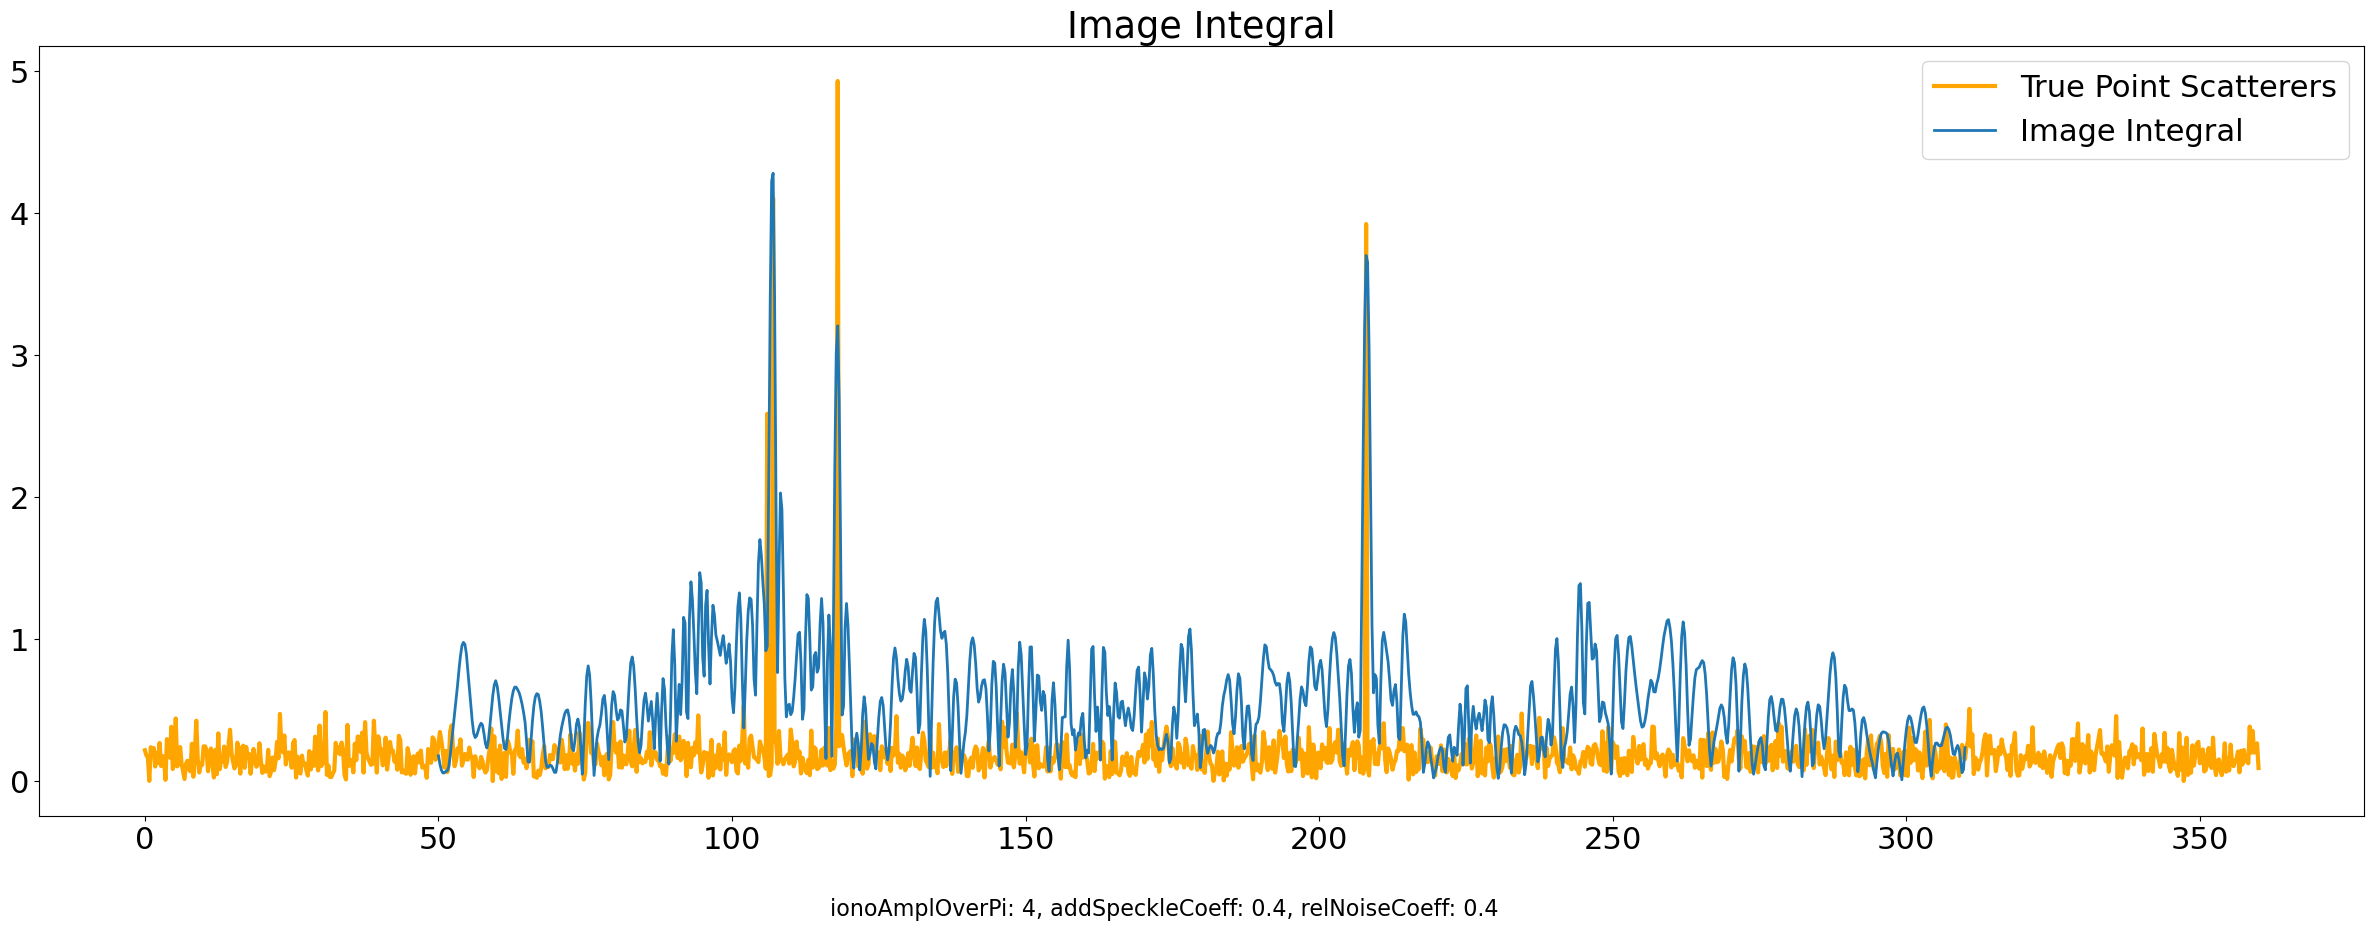

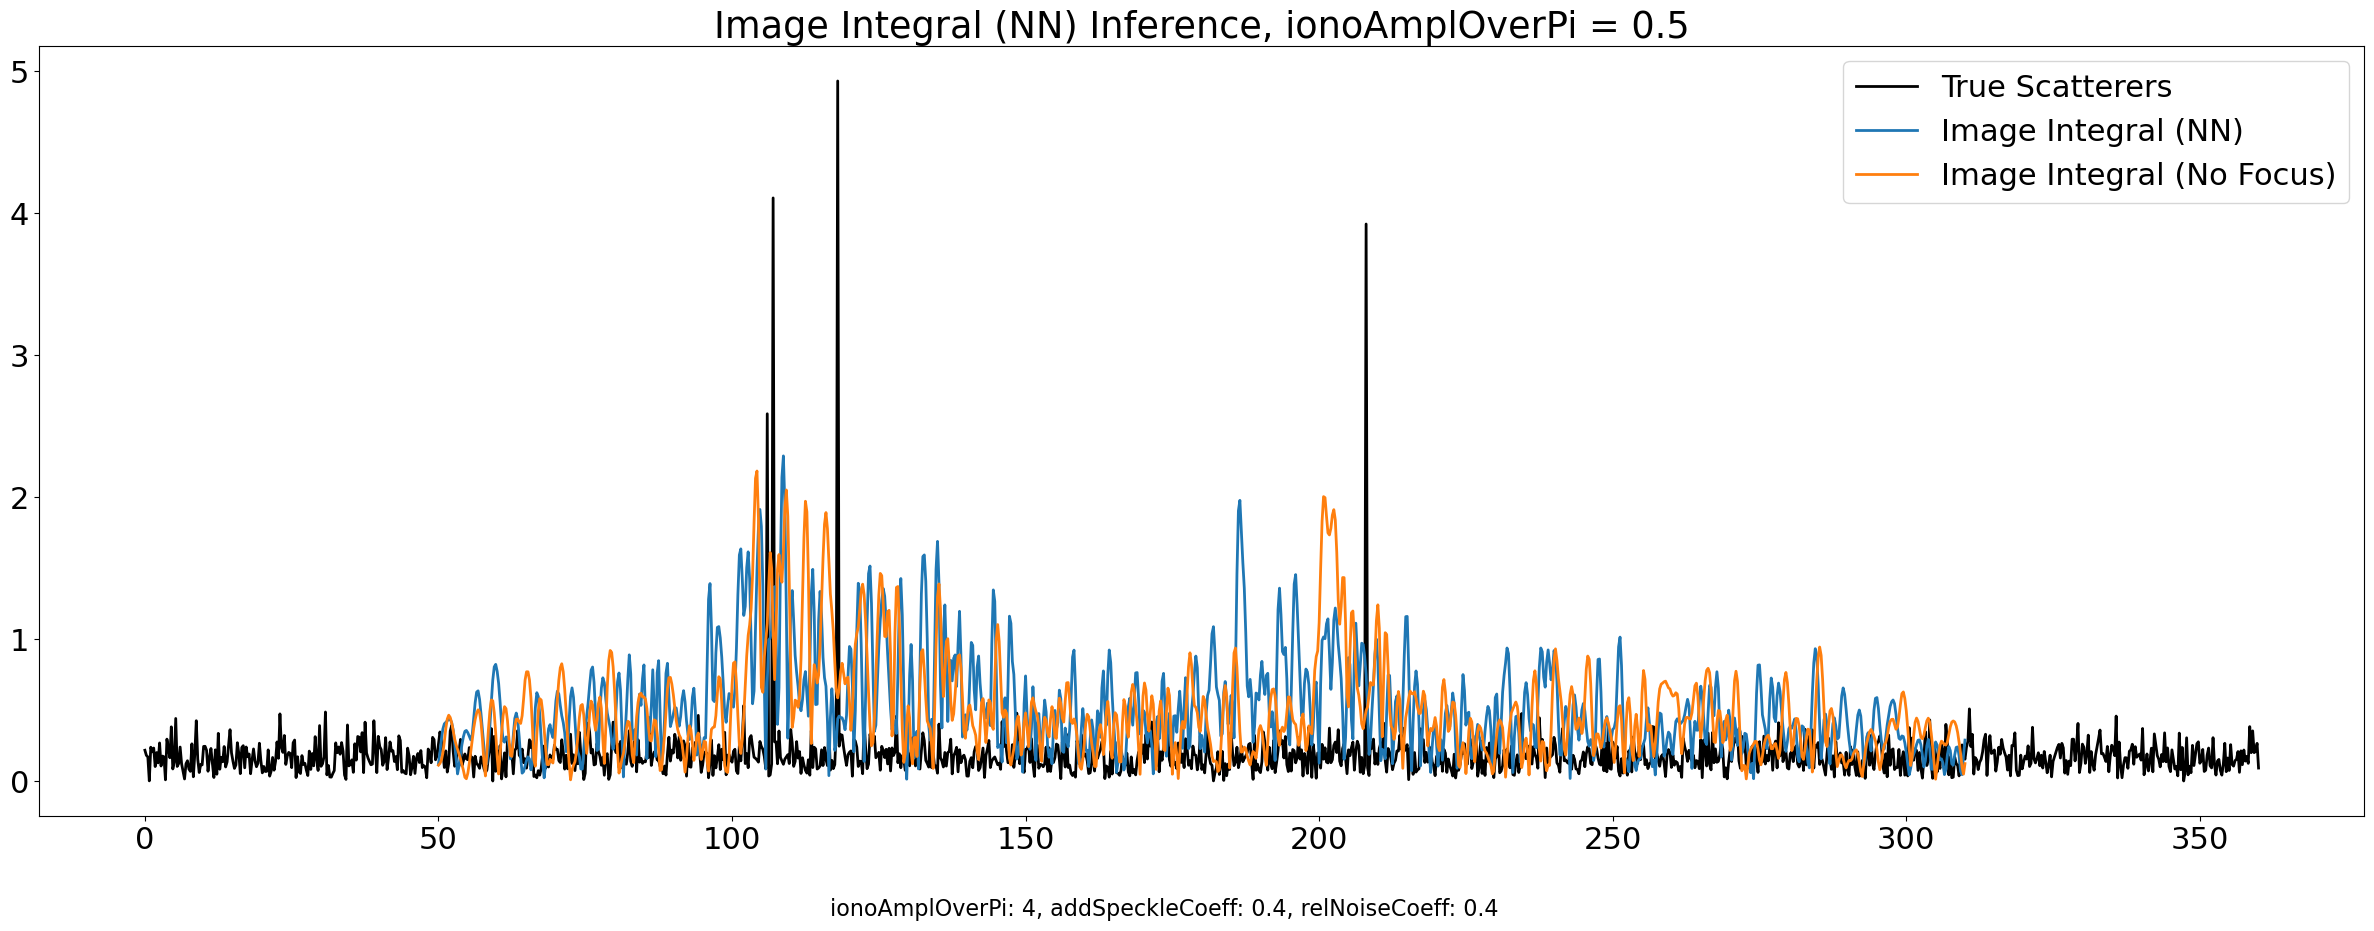

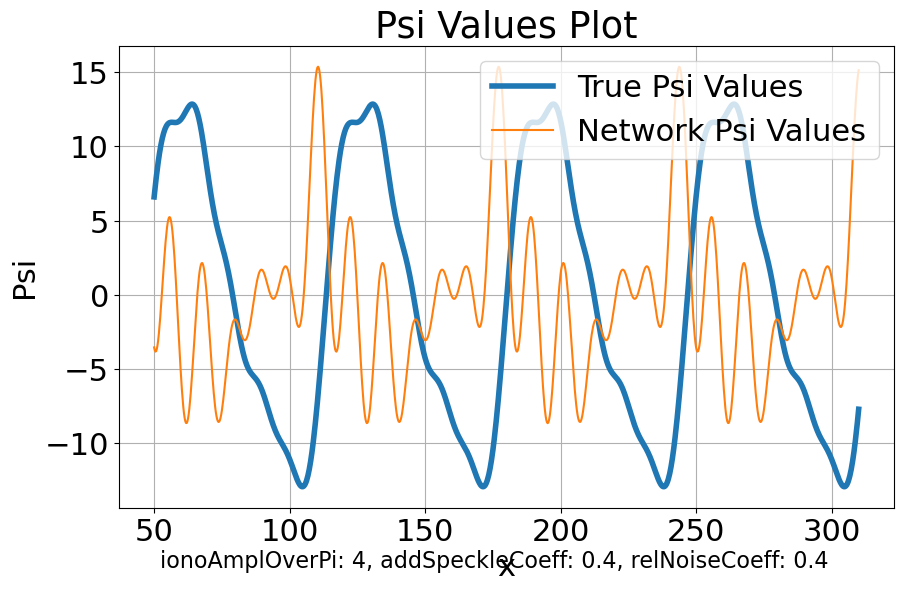

In [3]:

# Load data
x_range, setup, true_scatterers, signal_vals, kpsi_values, psi_coeffs_vals = load_data()

# === NEW PART: Trim leading/trailing zero-padding from signal ===
# If signal is complex, use magnitude for detecting zeros
signal_array = signal_vals[1, :]  # the 2nd row are the signal samples
zero_pad = 50
signal_trimmed = signal_array[4 * zero_pad : -4 * zero_pad]
x_range_trunc = x_range[4 * zero_pad : -4 * zero_pad]
signal_vals_trunc = np.vstack((x_range_trunc, signal_trimmed))




# Retrieve parameters
F, ionoNHarm, xi, windowType, sumType = (
    setup["F"], 
    setup["ionoNharm"], 
    setup["xi"], 
    setup["windowType"], 
    setup["sumType"],
)

# Split psi coefficients into cosine and sine components
cos_coeffs = [j.real for j in psi_coeffs_vals]
sin_coeffs = [-j.imag for j in psi_coeffs_vals]

# Create Psi object
rec_fourier_psi = RecFourierPsi(cos_coeffs, sin_coeffs, kpsi_values, ionoNHarm)
rec_fourier_psi.cache_psi(x_range_trunc, F, DX, xi)

# Create image object
image_object = Image(x_range_trunc, window_func=rect_window, signal=signal_vals_trunc, psi_obj=rec_fourier_psi, F=F)
image_integral = image_object._evaluate_image()

zero_psi = RecFourierPsi(np.zeros_like(cos_coeffs), np.zeros_like(sin_coeffs), kpsi_values, ionoNHarm)
zero_psi.cache_psi(x_range_trunc, F, DX, xi)
unfocused_image_object = Image(x_range_trunc, window_func = rect_window, signal = signal_vals_trunc, psi_obj = zero_psi, F = F)

# Plot results
plt.plot(x_range, true_scatterers, 'orange', lw=3)
plt.plot(x_range_trunc, np.abs(image_integral) / DX, lw=2)
plt.title("Image Integral")
add_plot_subtitle(setup)
plt.legend(["True Point Scatterers", "Image Integral"])
#plt.savefig("image_integral.png")



# Load model weights
# Load model weights
with open(MODEL_WEIGHTS_PATH, 'rb') as f:
    params = pickle.load(f)

# Define model architecture
architecture = [64,64,32,16]
model = ConfigurableModel(architecture=architecture, activation_fn=nn.ReLU)

# Load signal data and normalize
signal_df_full = pd.read_csv(SIGNAL_PATH_RELNOISE, dtype=str)
complex_matrix = signal_df_full.map(convert_to_complex).to_numpy().T
normalized_matrix = normalize_complex_to_unit_range(complex_matrix)
sample_fft = normalized_matrix[SAMPLE_IDX]

# Prepare model input
model_input = jnp.expand_dims(split_complex_to_imaginary(sample_fft), axis=0)

# Run inference
model.load_state_dict(params)
model.eval()
with torch.no_grad():
    input_array = np.array(model_input)          # Convert from JAX array to NumPy
    input_array.setflags(write=True)             # Make sure it's writeable
    input_tensor = torch.tensor(input_array, dtype=torch.float32)

    model_output = model(input_tensor)[0]     
half = model_output.shape[0] // 2
model_output_complex = model_output[:half] + 1j * model_output[half:]


# Split model output into cosine and sine coefficients
model_cos_coeffs = [j.real for j in model_output_complex]
model_sin_coeffs = [-j.imag for j in model_output_complex]

# Create model Psi object
model_rec_fourier_psi = RecFourierPsi(model_cos_coeffs, model_sin_coeffs, kpsi_values, ionoNHarm)
model_rec_fourier_psi.cache_psi(x_range_trunc, F, DX, xi)

# Create model image object
model_image_object = Image(x_range_trunc, window_func=rect_window, signal=signal_vals_trunc, psi_obj=model_rec_fourier_psi, F=F)
model_image_integral = model_image_object._evaluate_image()
zero_focus_integral = unfocused_image_object._evaluate_image()


# Plot model results
plt.figure()
plt.plot(x_range, true_scatterers, 'black', lw=2)
plt.plot(x_range_trunc, np.abs(model_image_integral)/DX, lw=2)
plt.plot(x_range_trunc, np.abs(zero_focus_integral)/DX, lw = 2)
plt.title("Image Integral (NN) Inference, ionoAmplOverPi = 0.5")
add_plot_subtitle(setup)
plt.legend(["True Scatterers", "Image Integral (NN)", "Image Integral (No Focus)"])
#plt.savefig("neural_image_integral.png")

# Compute Psi Values and Plot
model_psi_vals = build_psi_values(kpsi_values, model_output_complex, x_range_trunc)
true_psi_vals = build_psi_values(kpsi_values, psi_coeffs_vals, x_range_trunc)
print("MODEL OUT", model_output_complex)
print("MODEL ERROR", model_output_complex - psi_coeffs_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_range_trunc, true_psi_vals, label="True Psi Values", lw=4)
plt.plot(x_range_trunc, model_psi_vals, label="Network Psi Values")
plt.xlabel("x")
plt.ylabel("Psi")
plt.title("Psi Values Plot")
add_plot_subtitle(setup)
plt.grid(True)
plt.legend()
#plt.savefig('psi_comparison.png')


In [4]:

# Compute ISLR
islr_avg_nn = compute_islr(np.abs(model_image_integral) / DX, true_scatterers, x_range_trunc, ISLR_RADIUS, ISLR_RADIUS_RATIO, ISLR_MAIN_LOBE_WIDTH, DX)
print("ISLR Average (NN):", islr_avg_nn)

islr_avg_grad = compute_islr(np.abs(image_integral) / DX, true_scatterers, x_range_trunc, ISLR_RADIUS, ISLR_RADIUS_RATIO, ISLR_MAIN_LOBE_WIDTH, DX)
print("ISLR Average (Classic):", islr_avg_grad)


def calculate_l4_loss(image_integral, dx):
    return -1 * np.sum(np.abs(image_integral) ** 4) * dx

l4_pred = calculate_l4_loss(model_image_integral, DX)
l4_true = calculate_l4_loss(image_integral, DX)

    # === L4 Losses ===
def calculate_l4_loss(image_integral, dx):
    return -1 * np.sum(np.abs(image_integral) ** 4) * dx

l4_pred = calculate_l4_loss(model_image_integral, DX)
l4_true = calculate_l4_loss(image_integral, DX)

print(f"L4 Loss (NN Prediction, JAX-style Image class): {l4_pred:.6f}")
print(f"L4 Loss (Ground Truth, JAX-style Image class): {l4_true:.6f}")



print(f"L4 Loss (NN Prediction): {l4_pred:.6f}")
print(f"L4 Loss (Ground Truth): {l4_true:.6f}")

    # === Zoomed-in plots around each true scatterer (adjusted for trim offset) ===
ZOOM_RADIUS = 50
MAX_SUBPLOTS_PER_FIGURE = 10

# Original full x_range was trimmed: adjust index offset
trim_offset = 4*zero_pad # from earlier trimming logic
true_scatterers = np.array(true_scatterers)

# Get indices of nonzero scatterers in original signal
scatterer_indices_full = np.where(true_scatterers > 1)[0]

# Now adjust for the truncated domain
scatterer_indices = [i - trim_offset for i in scatterer_indices_full
                        if trim_offset <= i < trim_offset + len(x_range_trunc)]

total = len(scatterer_indices)

for batch_start in range(0, total, MAX_SUBPLOTS_PER_FIGURE):
    batch_end = min(batch_start + MAX_SUBPLOTS_PER_FIGURE, total)
    batch_indices = scatterer_indices[batch_start:batch_end]
    batch_size = len(batch_indices)

    ncols = 2
    nrows = (batch_size + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3 * nrows), squeeze=False)
    fig.suptitle(f"Zoomed-In Scatterers [{batch_start}–{batch_end - 1}]", fontsize=20)

    for i, local_idx in enumerate(batch_indices):
        start_idx_local = max(0, local_idx - ZOOM_RADIUS)
        end_idx_local = min(len(x_range_trunc), local_idx + ZOOM_RADIUS)

        x_zoom = x_range_trunc[start_idx_local:end_idx_local]
        true_zoom = np.abs(image_integral[start_idx_local:end_idx_local]) / DX
        model_zoom = np.abs(model_image_integral[start_idx_local:end_idx_local]) / DX
        zero_focus_zoom = np.abs(zero_focus_integral[start_idx_local:end_idx_local]) / DX

        ax = axes[i // ncols][i % ncols]
        ax.plot(x_zoom, true_zoom, label="True Image", lw=2)
        ax.plot(x_zoom, model_zoom, label="NN Image", lw=2)
        ax.plot(x_zoom, zero_focus_zoom, label="No Focus", lw=2)
        ax.axvline(x_range_trunc[local_idx], color='k', linestyle='--', label='Scatterer', lw=1)
        ax.set_title(f"Scatterer at x ≈ {x_range_trunc[local_idx]:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig(f"zoomed_scatterer_peaks_{batch_start}_{batch_end - 1}.png")
    plt.close()




ISLR Average (NN): 6.425166502594948
ISLR Average (Classic): 6.33135607233271
L4 Loss (NN Prediction, JAX-style Image class): -0.485656
L4 Loss (Ground Truth, JAX-style Image class): -2.124312
L4 Loss (NN Prediction): -0.485656
L4 Loss (Ground Truth): -2.124312


In [11]:
import torch
import torch.nn as nn

class RecFourierPsiTorch(nn.Module):
    def __init__(self, cosAmps, sinAmps, wavenums, xi=0.5):
        super().__init__()
        self.xi = xi
        self.register_buffer('wavenums', wavenums)
        self.cosAmps = nn.Parameter(cosAmps)
        self.sinAmps = nn.Parameter(sinAmps)

    def calc_sarr_linear(self, x, y):
        return self.xi * x + (1 - self.xi) * y

    def calc_psi(self, sarr):
        wavenum_sarr = torch.outer(sarr, self.wavenums)  # [Ns, Nw]
        cos_terms = torch.cos(wavenum_sarr) * self.cosAmps  # [Ns, Nw]
        sin_terms = torch.sin(wavenum_sarr) * self.sinAmps
        return torch.sum(cos_terms + sin_terms, dim=1)  # [Ns]

    def forward(self, sarr):
        return self.calc_psi(sarr)

    def calc_psi_cache(self, sarr):
        return self.calc_psi(sarr)  # compatible with original interface

def rect_window_torch(x):
    return torch.ones_like(x, dtype=torch.float64)  # constant window


def evaluate_image_differentiable_torch(domain, signal, psi_obj, window_func, F, dx, xi):
    """
    Differentiable version of Image._evaluate_image using PyTorch.
    """
    image_vals = []
    real_signal = signal[0, :].real # [Nx]
    complex_signal = signal[1, :]  # complex-valued tensor, [Nx]

    for y in domain:
        y = y.item() if isinstance(y, torch.Tensor) else y
        x0 = torch.max(real_signal[0], torch.tensor(y - F / 2))
        x1 = torch.min(real_signal[-1], torch.tensor(y + F / 2))
        mask = (real_signal >= x0) & (real_signal <= x1)

        base = real_signal[mask]
        signal_vals = complex_signal[mask]

        if base.numel() == 0:
            image_vals.append(torch.tensor(0.0, dtype=torch.cfloat, device=base.device))
            continue

        waveform = torch.exp(-1j * torch.pi * (base - y) ** 2 / F)
        sarr = psi_obj.calc_sarr_linear(base, torch.tensor(y))
        psi_vals = torch.exp(1j * psi_obj.calc_psi_cache(sarr))
        window = window_func(base)

        integrand = waveform * signal_vals * window * psi_vals
        integral = torch.trapz(integrand, base) / F
        image_vals.append(integral)

    return torch.stack(image_vals)  # shape: [len(domain)], complex

/tmp/ipykernel_100864/2883467325.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_cos_tensor = torch.tensor(model_output_complex_np.real, dtype=torch.float64)
/tmp/ipykernel_100864/2883467325.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_sin_tensor = torch.tensor(-model_output_complex_np.imag, dtype=torch.float64)
/tmp/ipykernel_100864/3905207558.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.max(real_signal[0], torch.tensor(y - F / 2))
/tmp/ipykernel_100864/3905207558.py:42: UserWarning: To copy cons

Text(0, 0.5, 'Amplitude')

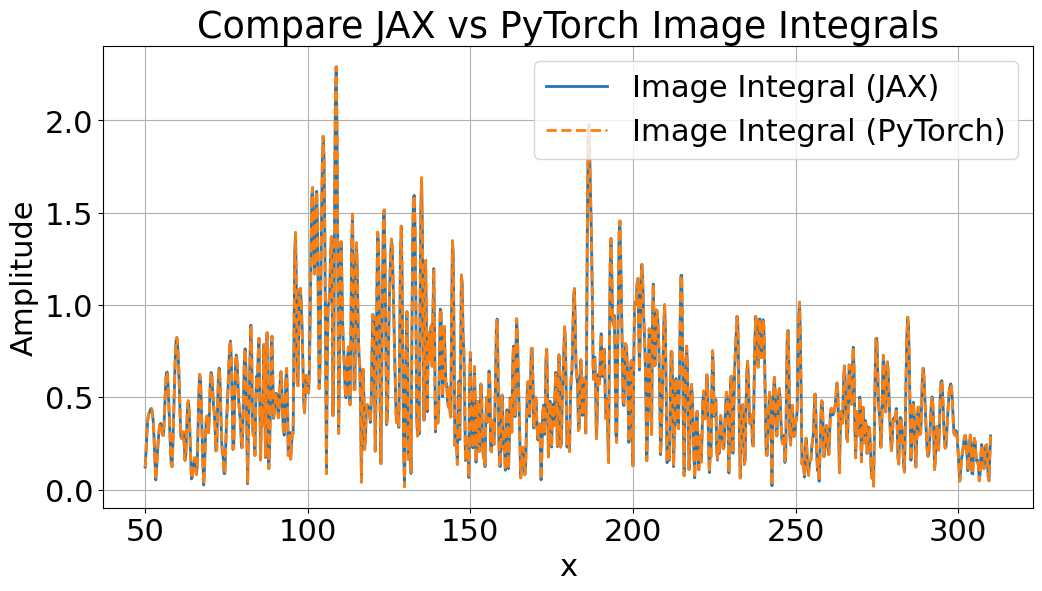

In [12]:
# === Convert model_output_complex to PyTorch cos/sin amps ===
model_output_complex_np = model_output_complex  # Already a NumPy array of complex numbers
model_cos_tensor = torch.tensor(model_output_complex_np.real, dtype=torch.float64)
model_sin_tensor = torch.tensor(-model_output_complex_np.imag, dtype=torch.float64)
wavenums_tensor = torch.tensor(kpsi_values, dtype=torch.float64)

# === Wrap input signal as PyTorch tensor ===
signal_tensor = torch.stack([
    torch.tensor(signal_vals_trunc[0], dtype=torch.float64),
    torch.tensor(signal_vals_trunc[1], dtype=torch.cfloat)
])

# === Wrap domain as PyTorch tensor ===
x_range_tensor = torch.tensor(x_range_trunc, dtype=torch.float64)

# === Create PyTorch Psi object ===
psi_model_torch = RecFourierPsiTorch(
    cosAmps=model_cos_tensor,
    sinAmps=model_sin_tensor,
    wavenums=wavenums_tensor,
    xi=xi,
)

# === Evaluate with differentiable PyTorch method ===
F_torch = torch.tensor(F, dtype=torch.float64)
DX_torch = torch.tensor(DX, dtype=torch.float64)

model_image_integral_torch = evaluate_image_differentiable_torch(
    domain=x_range_tensor,
    signal=signal_tensor,
    psi_obj=psi_model_torch,
    window_func=rect_window_torch,
    F=F_torch,
    dx=DX_torch,
    xi=xi
)


# === Compare original and PyTorch-generated integrals ===
plt.figure(figsize=(12, 6))
plt.plot(x_range_trunc, np.abs(model_image_integral)/DX, label='Image Integral (JAX)', lw=2)
plt.plot(x_range_trunc, np.abs(model_image_integral_torch.detach().cpu().numpy()) / DX, 
         label='Image Integral (PyTorch)', linestyle='--', lw=2)
plt.title("Compare JAX vs PyTorch Image Integrals")
plt.legend()
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Amplitude")



In [13]:
l4_pred = calculate_l4_loss(model_image_integral, DX)
l4_true_torch = calculate_l4_loss( np.abs(model_image_integral_torch.detach().cpu().numpy()), DX)

print(f"L4 Loss (NN Prediction, JAX-style Image class): {l4_pred:.6f}")
print(f"L4 Loss (Ground Truth, JAX-style Image class): {l4_true_torch:.6f}")

L4 Loss (NN Prediction, JAX-style Image class): -0.485656
L4 Loss (Ground Truth, JAX-style Image class): -0.485656


In [15]:
import torch

def compute_l4_image_loss_torch_no_class(
    x_range, signal_vals, model_output_complex, kpsi_values, F, dx, xi=0.5
):
    """
    Compute differentiable L4 image-domain loss directly from signal and predicted Fourier coefficients.

    Parameters:
        x_range:                (N,) array of spatial positions (numpy array)
        signal_vals:           (2, N) array with [x_vals; complex_signal] (numpy array)
        model_output_complex:  (Nh,) numpy array of complex-valued predicted Fourier coefficients
        kpsi_values:           (Nh,) array of wavenumbers (numpy array)
        F:                     scalar focusing aperture (float)
        dx:                    scalar integration step (float)
        xi:                    scalar mix parameter for s(x,y)

    Returns:
        l4_loss: scalar torch tensor (differentiable)
    """
    # === Convert inputs to torch tensors ===
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    domain = torch.tensor(x_range, dtype=torch.float64, device=device)
    real_signal = torch.tensor(signal_vals[0], dtype=torch.float64, device=device)
    complex_signal = torch.tensor(signal_vals[1], dtype=torch.cfloat, device=device)
    signal_tensor = torch.stack([real_signal, complex_signal])

    cosAmps = torch.tensor(model_output_complex.real, dtype=torch.float64, device=device)
    sinAmps = torch.tensor(-model_output_complex.imag, dtype=torch.float64, device=device)
    wavenums = torch.tensor(kpsi_values, dtype=torch.float64, device=device)
    F = torch.tensor(F, dtype=torch.float64, device=device)
    dx = torch.tensor(dx, dtype=torch.float64, device=device)

    # === Inner helper: compute psi(y) via Fourier series ===
    def calc_psi(sarr):
        wavenum_sarr = torch.outer(sarr, wavenums)  # [Ns, Nh]
        cos_terms = torch.cos(wavenum_sarr) * cosAmps  # [Ns, Nh]
        sin_terms = torch.sin(wavenum_sarr) * sinAmps
        return torch.sum(cos_terms + sin_terms, dim=1)  # [Ns]

    # === Image integral ===
    image_vals = []
    real_signal = signal_tensor[0, :].real
    complex_signal = signal_tensor[1, :]

    for y in domain:
        y = y.item()
        x0 = torch.max(real_signal[0], torch.tensor(y - F / 2, dtype=torch.float64, device=device))
        x1 = torch.min(real_signal[-1], torch.tensor(y + F / 2, dtype=torch.float64, device=device))
        mask = (real_signal >= x0) & (real_signal <= x1)

        base = real_signal[mask]
        signal_segment = complex_signal[mask]

        if base.numel() == 0:
            image_vals.append(torch.tensor(0.0, dtype=torch.cfloat, device=device))
            continue

        waveform = torch.exp(-1j * torch.pi * (base - y) ** 2 / F)
        sarr = xi * base + (1 - xi) * y
        psi_vals = torch.exp(1j * calc_psi(sarr))
        window = torch.ones_like(base, dtype=torch.float64)

        integrand = waveform * signal_segment * window * psi_vals
        integral = torch.trapz(integrand, base) / F
        image_vals.append(integral)

    image_vec = torch.stack(image_vals)  # (Ny,) complex
    l4_loss = -torch.sum(torch.abs(image_vec) ** 4) * dx
    return l4_loss


l4_loss = compute_l4_image_loss_torch_no_class(
    x_range=x_range_trunc,
    signal_vals=signal_vals_trunc,
    model_output_complex=model_output_complex,
    kpsi_values=kpsi_values,
    F=F,
    dx=DX,
    xi=xi
)
print(l4_loss)

/tmp/ipykernel_100864/808435932.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cosAmps = torch.tensor(model_output_complex.real, dtype=torch.float64, device=device)
/tmp/ipykernel_100864/808435932.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sinAmps = torch.tensor(-model_output_complex.imag, dtype=torch.float64, device=device)
/tmp/ipykernel_100864/808435932.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.max(real_signal[0], torch.tensor(y - F / 2, dtype=torch.float64, device=device))
/tmp/ipykernel_100864/80

tensor(-0.4857, device='cuda:0', dtype=torch.float64)
